## Location-Based Market Clustering

This exercise builds on our initial market comparison work. Instead of building individual models for each location, we'll use clustering to group similar markets together and build models for each cluster.

### Our Goals:
1. Understand what makes markets similar
2. Use clustering to group markets effectively
3. Balance model accuracy with market coverage
4. Compare cluster-based models to national models

### Key Steps:
1. Compare locations across different dimensions
2. Choose a representative make/model
3. Cluster locations using appropriate distance metrics
4. Build and evaluate cluster-specific models

**Note to UST Faculty**: Typically we would connect to GBQ for the data, but to ensure access the data can be reached via [this link](https://www.dropbox.com/t/H5lPzrmt29Oq1F5V). Download this zip and extract the contents into a folder called `data/` within the repository. 

---


### Exercise Boilerplate

#### Purpose of Exercises
Exercises are a critical part of this class. While lectures and readings introduce concepts, exercises help you:
- Develop practical implementation skills
- Understand common pitfalls and debugging strategies
- Build intuition through experimentation
- Create a portfolio of working examples
- Practice real-world data analysis workflows

#### Using These Notebooks
- **Dive Right In**: These exercises often reveal unexpected challenges
- **Work Incrementally**: Test each step before moving forward
- **Ask Questions**: Use class Teams for help, ask your instructor, ask classmates
- **Compare Solutions**: Solutions are available to you in this folder
- **Save Your Work**: Commit working versions to your repository

#### Using AI Assistants
AI coding assistants (ChatGPT, Claude, GitHub Copilot, etc.) are powerful tools that you'll use in your career. In this class:
- ✅ Use AI to understand code snippets
- ✅ Use AI to debug errors
- ✅ Use AI to explore alternative approaches
- ✅ Use AI to explain concepts
- ❌ Don't just paste the whole exercise
- ❌ Don't submit AI-generated code without understanding it

Document your AI interactions in a comment block and include a link to your chat:
```python
# AI Interaction Log:
# 1. Asked Claude to explain the difference between train_test_split and TimeSeriesSplit
# 2. Used GitHub Copilot to help write data validation functions
# 3. Had ChatGPT debug a pandas groupby error
# 4. Chat logs are available here: https://chatgpt.com/c/671d1f08-1ebc-8011-a128-8a29255f24fe
```

#### Evaluation
Exercises are not evaluated by your instructor. They are for your learning.

### Setup
First, we'll load our required libraries and prepare our data sources. We need libraries for data manipulation, clustering, modeling, and visualization.

---

In [12]:
# Core data & analysis
import pandas as pd
import numpy as np
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Clustering specific
from sklearn_extra.cluster import KMedoids
import gower 

# Display
from IPython.display import display, Markdown

### Helper Functions
We'll reuse some functions from our previous exercise and add clustering-specific functionality.

In [2]:
# Core functions from previous exercise
def load_data():
    """Load car listing data and do initial filtering"""
    listings = pd.read_csv('../data/processed_listing_pages.csv')
    listings['age'] = 2024 - listings['year']
    return listings

def get_features(data):
    """Create feature matrix for modeling"""
    return pd.DataFrame({
        'age': data['age'],
        'log_odometer': data['log_odometer'],
        'age_miles': data['age'] * data['log_odometer'],
        'condition_mapped': data['condition_mapped']
    })

def filter_data(data, make, model, location=None):
    """Filter data for specific make/model and optional location"""
    mask = (data['make'] == make) & (data['model'] == model)
    if location:
        mask = mask & (data['location'] == location)
    return data[mask].copy()

def create_model(X, y):
    """Create and fit a linear regression model"""
    model = LinearRegression()
    model.fit(X, y)
    return model

def evaluate_model(model, X, y):
    """Calculate model performance metrics"""
    pred = model.predict(X)
    return {
        'rmse': root_mean_squared_error(y, pred),
        'mae': mean_absolute_error(y, pred),
        'r2': r2_score(y, pred)
    }

# For pretty printing results
def create_markdown_table(metrics, title):
    table = f"### {title}\n\n"
    table += "| Metric | Value |\n"
    table += "|--------|-------|\n"
    for key, value in metrics.items():
        table += f"| {key.upper()} | {value:.2f} |\n"
    return table

# New helper for cluster modeling
def build_cluster_model(data, needed_obvs=50):
    """Build model for a cluster if enough data exists"""
    if len(data) < needed_obvs:
        return {
            'n_obs': len(data),
            'rmse': np.nan,
            'mae': np.nan,
            'r2': np.nan,
            'price': np.mean(data['price'])
        }
    
    X = get_features(data)
    y = data['price']
    model = create_model(X, y)
    metrics = evaluate_model(model, X, y)
    metrics['n_obs'] = len(data)
    metrics['price'] = np.mean(y)
    
    return metrics

### Load and Explore Market Data
First, we'll load our market data and look at the characteristics that might make markets similar.

In [7]:
# Load location summaries and listing data
loc_data = pd.read_csv("../data/location_summary_data.csv")
listing_data = load_data()

# Look at a few example markets
example_markets = ['seattle', 'newyork', 'houston']
market_comparison = loc_data[loc_data['location'].isin(example_markets)]
display(market_comparison)

# Create distance matrix using Gower distance
market_features = loc_data.drop('location', axis=1)
# Convert categorical variables to factors
market_features['state'] = pd.Categorical(market_features['state']).codes
market_features['census_region'] = pd.Categorical(market_features['census_region']).codes



,location,state,census_region,mean_latitude,mean_longitude,total_listings,avg_price,avg_mileage,avg_age,fraction_before_2014,...,old_f150_count,new_civic_price,new_civic_count,old_civic_price,old_civic_count,new_accord_price,new_accord_count,old_accord_price,old_accord_count,pam_clustering
43,newyork,New York,Northeast,40.606168,-73.699905,55368,10227.16,131162,14.497,0.6604,...,229.0,14209.99,359.0,5267.73,639.0,11946.47,438.0,5446.29,864.0,5
133,houston,Texas,South,29.739359,-95.229713,55015,11164.54,149518,16.022,0.6636,...,1098.0,11755.20,217.0,4778.72,441.0,13280.49,488.0,5242.78,685.0,2
343,seattle,Washington,West,47.361353,-122.065335,93437,12294.31,147638,21.138,0.7941,...,1061.0,15849.47,270.0,5319.38,771.0,14596.20,229.0,5953.84,588.0,3


### Implement Clustering
We'll use k-means clustering with k=8 based on our market exploration. This gives us reasonable market sizes while maintaining geographic coherence.

In [17]:
# Prepare data for clustering
# First separate numeric and categorical columns
cat_cols = ['state', 'census_region']
num_cols = [col for col in loc_data.columns 
            if col not in cat_cols + ['location']]

# Create feature matrix ensuring proper ordering
cluster_features = loc_data[num_cols + cat_cols].copy()

# Fill missing values with column means
cluster_features = loc_data[num_cols + cat_cols].copy()
cluster_features[num_cols] = cluster_features[num_cols].fillna(
    cluster_features[num_cols].mean()
)
# Calculate Gower distance matrix
gower_dist = gower.gower_matrix(cluster_features)


In [18]:
# Use PAM/KMedoids on the distance matrix
k = 8
pam = KMedoids(n_clusters=k, random_state=42, metric='precomputed')
market_clusters = pam.fit_predict(gower_dist)

# Add clusters back to location data
loc_data['cluster'] = market_clusters

# See cluster sizes and characteristics
print("\nCluster Sizes:")
print(pd.Series(market_clusters).value_counts().sort_index())

# Examine cluster characteristics
cluster_summary = loc_data.groupby('cluster').agg({
    'total_listings': 'mean',
    'avg_price': 'mean',
    'census_region': lambda x: x.mode()[0],
    'state': lambda x: x.mode()[0]
}).round(2)

display(cluster_summary)

# Optional: Look at most similar markets to a specific market
example_market = 'seattle'
market_idx = loc_data[loc_data['location'] == example_market].index[0]
distances = gower_dist[market_idx]
similar_idx = np.argsort(distances)[:5]  # Get 5 most similar
similar_markets = loc_data.iloc[similar_idx]
print(f"\nMarkets most similar to {example_market}:")
display(similar_markets[['location', 'cluster', 'total_listings', 'avg_price']])


Cluster Sizes:
0     40
1     43
2     22
3     96
4     24
5     15
6     17
7    156
Name: count, dtype: int64


,total_listings,avg_price,census_region,state
cluster,,,,
0,5410.38,11679.00,South,Florida
1,6116.07,12396.30,South,Texas
2,9319.95,10918.32,South,North Carolina
3,16267.49,12955.44,West,California
4,1318.04,12823.49,South,West Virginia
5,3089.00,11964.22,South,Tennessee
6,2324.06,10937.57,South,Virginia
7,4155.74,10892.02,Midwest,Michigan



Markets most similar to seattle:


,location,cluster,total_listings,avg_price
343,seattle,3,93437,12294.31
5,spokane,3,25742,12707.25
98,portland,3,91471,12288.44
310,sacramento,3,78197,12246.05
251,kpr,3,7343,11251.58


### Choose Make/Model and Build Models
Now we'll select a popular make/model combination and compare national vs cluster-specific models.

In [19]:
# Select make/model and merge cluster assignments
make = 'ford'
model_name = 'f150'
mm_data = filter_data(listing_data, make, model_name)
mm_data = mm_data.merge(loc_data[['location', 'cluster']], on='location', how='left')

print(f"Total {make} {model_name} listings: {len(mm_data)}")
print("\nListings per cluster:")
display(mm_data.groupby('cluster')['price'].count().sort_values(ascending=False))

Total ford f150 listings: 27787

Listings per cluster:


cluster
3    13309
7     5772
1     3554
0     2258
2     1596
5      562
6      446
4      290
Name: price, dtype: int64

### Build and Compare Models
Now that we have our market clusters, let's:
1. Build a national model for our chosen make/model
2. Build separate models for each cluster
3. Compare the performance across approaches

In [20]:

# Build national model
X_national = get_features(mm_data)
y_national = mm_data['price']
national_model = create_model(X_national, y_national)
national_metrics = evaluate_model(national_model, X_national, y_national)

# Build cluster models and evaluate
cluster_results = []
for cluster_id in range(k):
    cluster_data = mm_data[mm_data['cluster'] == cluster_id]
    metrics = build_cluster_model(cluster_data, needed_obvs=50)
    metrics['cluster'] = cluster_id
    cluster_results.append(metrics)

cluster_results = pd.DataFrame(cluster_results)

# Calculate summary statistics
n_markets_with_models = sum(~cluster_results['rmse'].isna())
total_coverage = cluster_results['n_obs'].sum() / len(mm_data)
avg_improvement = ((national_metrics['rmse'] - cluster_results['rmse'].mean()) 
                  / national_metrics['rmse'] * 100)

print(f"Coverage Statistics:")
print(f"Markets with models: {n_markets_with_models} of {k}")
print(f"Total coverage: {total_coverage:.1%}")
print(f"Average RMSE improvement: {avg_improvement:.1f}%")

Coverage Statistics:
Markets with models: 8 of 8
Total coverage: 100.0%
Average RMSE improvement: 10.9%


### Visualize Results
Let's create some visualizations to understand our clusters and their performance.

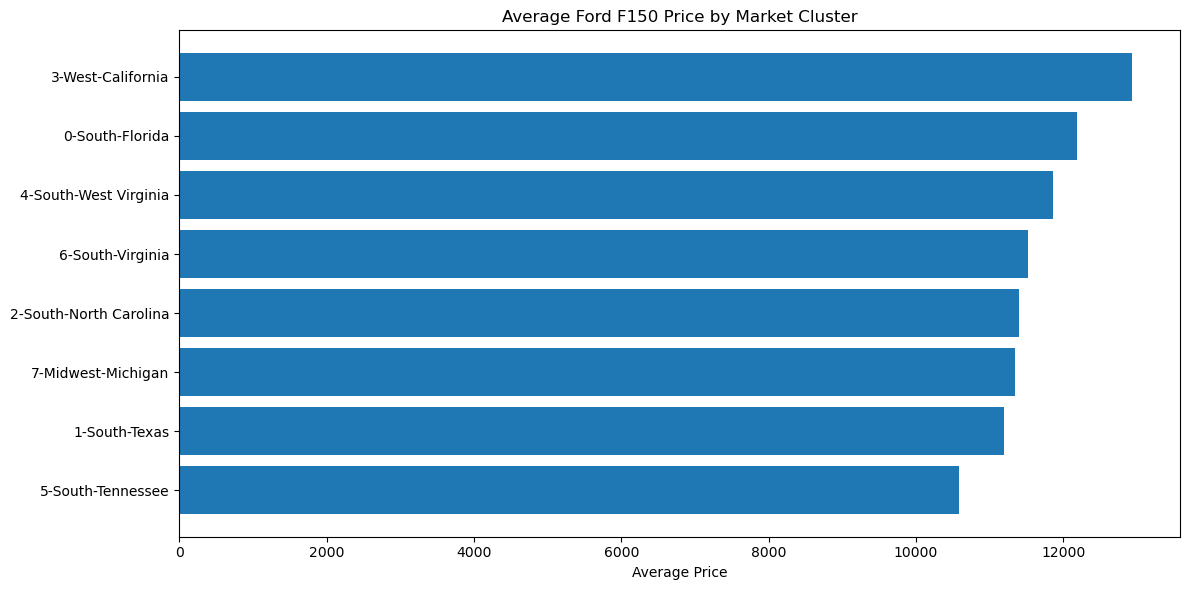

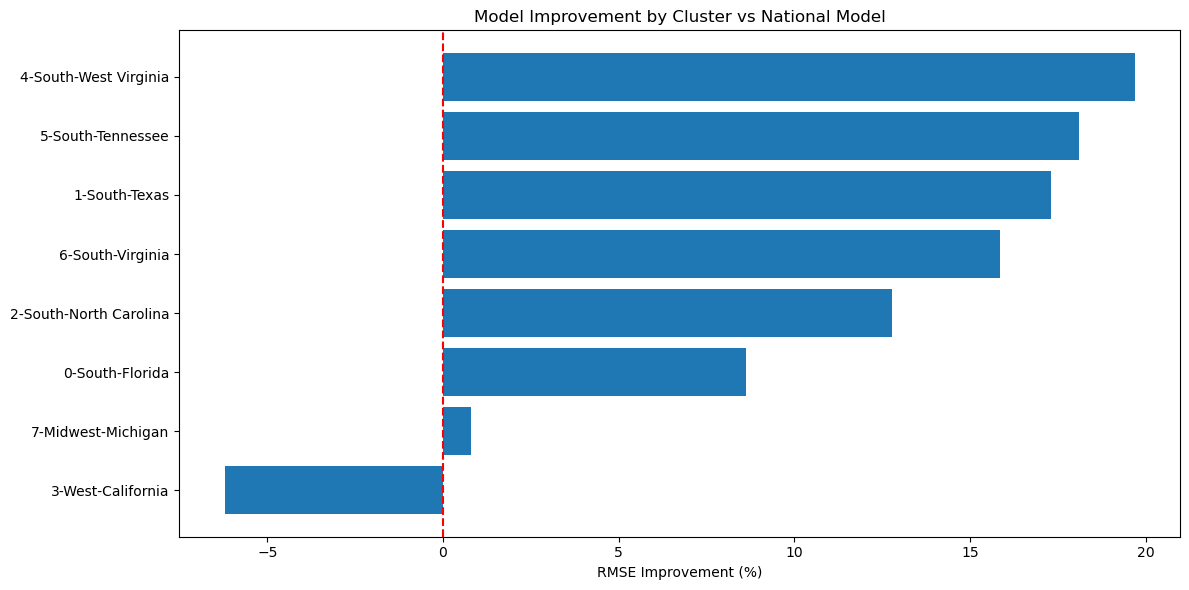

In [21]:
# Create cluster name mapping
cluster_names = loc_data.groupby('cluster').agg({
    'census_region': lambda x: x.mode()[0],
    'state': lambda x: x.mode()[0]
}).apply(lambda x: f"{x.name}-{x['census_region']}-{x['state']}", axis=1)

# Plot average prices by cluster
plt.figure(figsize=(12, 6))
cluster_results['avg_price'] = cluster_results['price']  # from build_cluster_model
plot_data = cluster_results.sort_values('avg_price', ascending=True)
plt.barh(range(len(plot_data)), plot_data['avg_price'])
plt.yticks(range(len(plot_data)), 
          [cluster_names[i] for i in plot_data['cluster']])
plt.xlabel('Average Price')
plt.title(f'Average {make.title()} {model_name.upper()} Price by Market Cluster')
plt.tight_layout()
plt.show()

# Plot RMSE improvement
plt.figure(figsize=(12, 6))
improvement = (national_metrics['rmse'] - cluster_results['rmse']) / national_metrics['rmse'] * 100
plot_data = cluster_results.assign(improvement=improvement).sort_values('improvement')
plt.barh(range(len(plot_data)), plot_data['improvement'])
plt.yticks(range(len(plot_data)), 
          [cluster_names[i] for i in plot_data['cluster']])
plt.axvline(x=0, color='red', linestyle='--')
plt.xlabel('RMSE Improvement (%)')
plt.title('Model Improvement by Cluster vs National Model')
plt.tight_layout()
plt.show()